# Yelp Rising Stars Analysis 
## Overview
Identifying businesses with significant rating improvement over time using SQL and Python visualization.

- YoY (Last data was 2021 - 2022)


## SQL Query
Filters businesses with at least 10 reviews in the past year and a rating increase of 1+ star.

```sql
SELECT previous_period, current_period, name, current_review_count, 
       current_avg_stars, prior_avg_stars, current_rating_improvement 
FROM yelp_analytics.datamart_rising_star_businesses
WHERE period_type = 'YoY' AND current_rating_improvement >= 1
      AND current_review_count >= 10
ORDER BY previous_period DESC, current_rating_improvement DESC;
```

## Data Preparation
- Create `period_label` by combining `previous_period` and `current_period`.
- Extract unique periods to structure visualizations.
- Look the tip that given to rising stars





## This is the rising star from latest data (2021-2022)

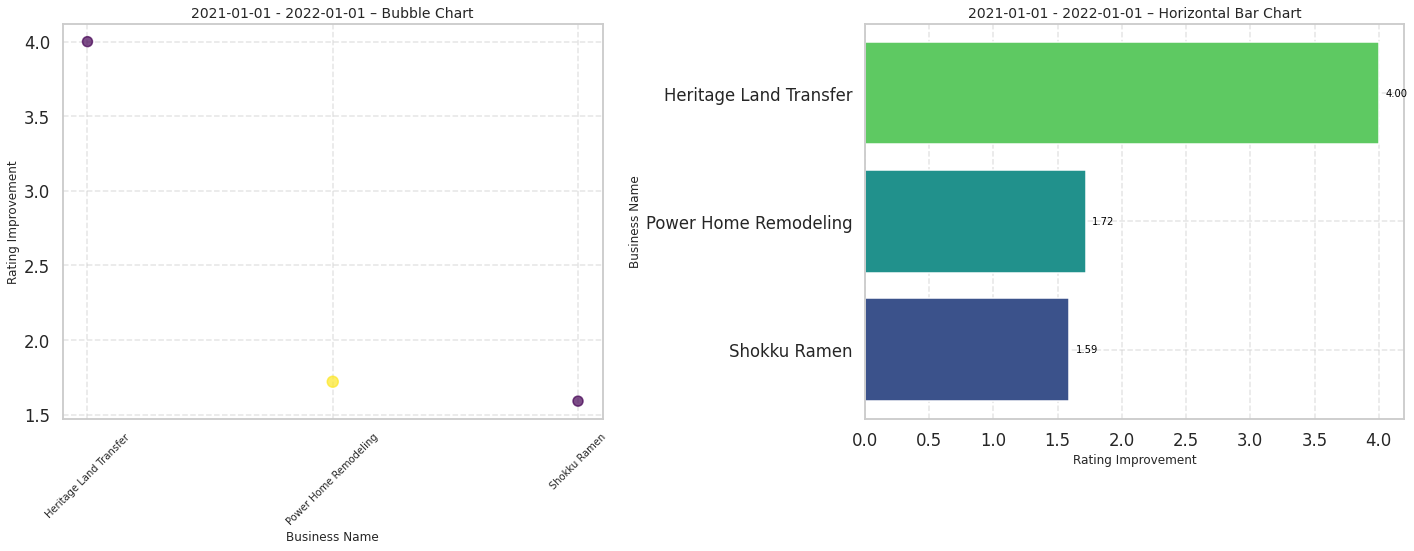

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

query = """
SELECT 
    previous_period, 
    current_period, 
    name,
    current_review_count, 
    current_avg_stars, 
    prior_avg_stars, 
    current_rating_improvement 
FROM yelp_analytics.datamart_rising_star_businesses r
WHERE period_type = 'YoY' 
    AND current_rating_improvement >= 1
    AND current_review_count >= 10
ORDER BY previous_period asc, current_rating_improvement DESC
"""

df = spark.sql(query).toPandas()
df["period_label"] = df["previous_period"].astype(str) + " - " + df["current_period"].astype(str)

# Filter to only the latest YoY period
latest_period = df["period_label"].unique()[-1]
df_latest = df[df["period_label"] == latest_period].head(10)

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Bubble Chart: Business names vs rating improvement, bubble size reflects review count
sizes = df_latest["current_review_count"] * 10
scatter = axs[0].scatter(
    df_latest["name"], df_latest["current_rating_improvement"],
    s=sizes, alpha=0.7, c=sizes, cmap="viridis"
)
axs[0].set_title(f"{latest_period} – Bubble Chart", fontsize=14)
axs[0].set_xlabel("Business Name", fontsize=12)
axs[0].set_ylabel("Rating Improvement", fontsize=12)
axs[0].tick_params(axis="x", rotation=45, labelsize=10)
axs[0].grid(True, linestyle="--", alpha=0.5)

# Horizontal Bar Chart: Rank businesses by rating improvement
df_sorted = df_latest.sort_values(by="current_rating_improvement", ascending=True)
bars = axs[1].barh(df_sorted["name"], df_sorted["current_rating_improvement"],
                    color=sns.color_palette("viridis", len(df_sorted)))
axs[1].set_title(f"{latest_period} – Horizontal Bar Chart", fontsize=14)
axs[1].set_xlabel("Rating Improvement", fontsize=12)
axs[1].set_ylabel("Business Name", fontsize=12)
for i, v in enumerate(df_sorted["current_rating_improvement"]):
    axs[1].text(v + 0.05, i, f"{v:.2f}", color='black', va='center', fontsize=10)
axs[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


##and this is all the tips from user that given to rising star

Tabular Results:
           business_name                 user_id  \
0  Power Home Remodeling  GkPZSx5hyul4lvzpm7t3Yw   
1           Shokku Ramen  Gq85H61wiFHZa81240KP1w   
2  Power Home Remodeling  dQEPoOnc-mVIm3d0xNveXg   
3  Power Home Remodeling  lgiw-7FkzaVzcJseAITrGg   
4  Power Home Remodeling  o461cVw2I4wICxCRIYCulA   

                                           tip_texts  total_tip  
0  [Emailed the address above a week ago and stil...          1  
1                  [So good, never had better ramen]          1  
2  [I just found their sales send me a threatenin...          1  
3  [Never spoke to more ignorant people.  Overpri...          1  
4          [5 stars. Greatest company in the world.]          1  


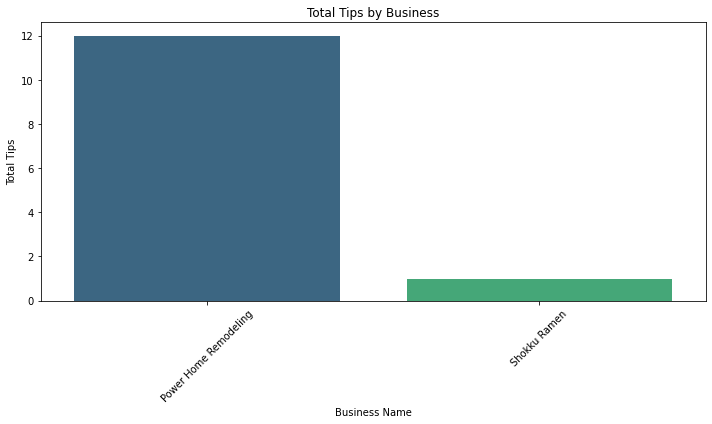

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Run the query and load the results into a Pandas DataFrame
query = """
WITH yoy_rising AS (
    SELECT 
        business_id, 
        name as business_name
    FROM yelp_analytics.datamart_rising_star_businesses
    WHERE period_type = 'YoY'
      AND current_rating_improvement >= 1
      AND current_review_count >= 10
      AND current_period = '2022'
      AND business_id IN (
    
SELECT 
    
    business_id
   
FROM yelp_analytics.datamart_rising_star_businesses r
WHERE period_type = 'YoY' 
    AND current_rating_improvement >= 1
    AND current_review_count >= 10
    AND current_period = '2022'


)
),
tips_agg AS (
    SELECT 
        t.business_id,
        t.user_id,
        array_agg(t.text) AS tip_texts,
        COUNT(*) AS total_tip
    FROM yelp_analytics.fact_tip t
    WHERE t.business_id IN (SELECT business_id FROM yoy_rising)
    GROUP BY t.business_id, t.user_id
)
SELECT 
    y.business_name,
    t.user_id,
    t.tip_texts,
    t.total_tip
FROM tips_agg t
JOIN yelp_analytics.dim_user u
    ON t.user_id = u.user_id
JOIN yoy_rising y
    ON t.business_id = y.business_id
ORDER BY t.total_tip DESC
"""

# Execute the SQL query via Spark
df_tips = spark.sql(query).toPandas()

# Display the resulting table (you can also use display(df_tips) in Databricks)
print("Tabular Results:")
print(df_tips.head())

# Visualization: Aggregate total tips by business
tips_by_business = df_tips.groupby("business_name")["total_tip"].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=tips_by_business, x="business_name", y="total_tip", palette="viridis")
plt.title("Total Tips by Business")
plt.xlabel("Business Name")
plt.ylabel("Total Tips")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
